<center><h1> SageMaker Text Analysis </h1></center>

# 1. Information

Используя файл lang_data.csv решить задачу текстовой классификации для текстов на английском, голландском и африкаанс. Сделать реализацию в Sagemaker.

# 2. Fetching Data:

## 2.1 Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline

from collections import OrderedDict
import requests

pd.set_option('display.max_columns', 100)

import boto3, os, io
import sagemaker

## 2.2 Import data

In [2]:
df=pd.read_csv('lang_data-40121-290127.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.isna().sum()

text        0
language    0
dtype: int64

In [5]:
df.shape

(2761, 2)

In [6]:
df.head(10)

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English
5,Sy kan altyd my battery natpiepie.,Afrikaans
6,When the shit hits the fan,English
8,Egg on,English
9,Drag race,English
10,As queer as a nine bob note,English


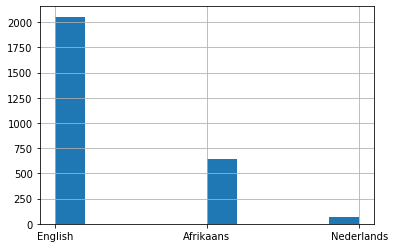

In [7]:
df['language'].hist()

Выборка очень несбалансированная.

# 3 Machine learning 

## 3.1 Import packages

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
comprehend = boto3.client('comprehend', region_name='us-east-1')

## 3.2 Language Classification

Ну, раз у нас есть такой замечательный инструмент как **Amazon Comprehend**, то почему бы им не воспользоваться? К тому же он поддерживает распознавание **Afrikaans**.  
Поскольку нейронка уже обучена, то нет смысла обучать ее на нашем маленьком датасете. Следует всю выборку взять как тестовую.

In [9]:
y_test = df['language']

In [10]:
def plot_confusion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data = cm)
    plt.figure(figsize = (5,5))
    ax=sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [11]:
def language_class (data = df, size = -1):
    size = data.shape[0] if size ==-1 else size
    comp_result = [comprehend.detect_dominant_language(Text = i)['Languages'] for i in data.head(size)['text']]
    comp2_res = ['nl' if len(i)>1 and (i[0] or i[1])== 'nl' else i[0] for i in comp_result]
    comp3_res = ['English' if i['LanguageCode'] == 'en' else 'Afrikaans' if i['LanguageCode'] == 'af' else \
             'Nederlands' for i in comp2_res]
    return comp3_res

In [12]:
y_pred = language_class(data = df)

In [13]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

   Afrikaans       0.83      1.00      0.91       529
     English       0.99      0.99      0.99      2038
  Nederlands       1.00      0.35      0.51       194

    accuracy                           0.95      2761
   macro avg       0.94      0.78      0.80      2761
weighted avg       0.96      0.95      0.94      2761



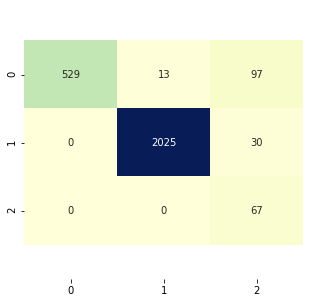

In [14]:
plot_confusion(y_test, y_pred)

# 4. Conclusion

С учетом того, что выборка сильно несбалансированная, получился очень неплохой результат.  
Ожидаемо классификатор путается в определении **Afrikaans** и **Nederlands**.  
Самое приятное, что благодаря **SageMaker** и **Amazon Comprehend** работа заняла минимум времени. 